In [1]:
# -*- coding: utf-8 -*-
"""
Created on Tue Dec 15 02:10:11 2020


@author: f.divruno
@author: Braam Otto

Last updated: 29 March 2021
"""

import astropy.units as u
import astropy.constants as const
import numpy as np
import time
import matplotlib.pyplot as plt
import sys
import pycraf.protection as protection
from pycraf import conversions as cnv

sys.path += ['../src']

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
if os.name == 'nt':
    os.system('cls')
else:
    os.system('clear')

import ska
from ska import  constellation, telescope



In [2]:
ska

<module 'ska' from '../src\\ska\\__init__.py'>

In [3]:

#%% Simulation parameters


# # Quijote
observer_name = 'Quijote'
observer_geo = np.array((-16.3, 28.18, 0.100)) # deg, deg, km
observer_diam = 2.25*u.m


# SKA-Mid
# observer_name = 'SKA-MID'
# observer_geo = np.array((21.443800, -30.712919, 1.052)) # deg, deg, km
# observer_diam = 15*u.m

# #Effelsberg
# observer_name = 'Effelsberg'
# observer_geo = np.array((6, 50.7, 0.2)) # deg, deg, km
# observer_diam = 100*u.m

# Sky coordinates
equatorial_coords = 1
min_dec = -90
max_dec = 30


# Simulation frequency
freq = 12 * u.GHz #use the centre freq as approximation

# number of times the constellation and tesselation is calculated
Niters = 1

# number of time steps
Ntime = 20

#length of a time step
time_step = 1 #seconds

# channel bandwidth
BW = 10 * u.MHz

# avoidance angle 
# optional parameter only used for steerable beams constellations
avoid_angle = 0 * u.deg

# Masking:
# masking in the signal chain: a time vector could be defined when a satellite
# has a boresight angle less than a defined value
# In real life this requires good knowledge of the ephemerides of satellites and
# propagation of them.
masking = False
boresight_limit = 1 * u.deg

# Power flagging:
# flag the received power higher than this limit
# of received power in a 4 kHz BW
power_flag = True
T = 200 * u.K # Kelvin
B = 1 *u.Hz#4e3 * u.Hz  # Hz (4 kHz)
k_b = 1.3806E-23 
Plim = (T*k_b * u.W * u.s / u.K).to(u.W/u.Hz)

print("Tsys = ", T)
print("BW = ", B)
print("Plim/Hz = kT = ", 10.*np.log10(Plim.value/1E-3), "dBm/Hz")


RA769_lim = protection.ra769_calculate_entry(freq,1*u.Hz,1e-8*u.K,T)[3]

print("Protection thresgolds as defined in RA.769: %.2f dBW/m2/Hz"%RA769_lim.value)


Tsys =  200.0 K
BW =  1.0 Hz
Plim/Hz = kT =  -175.5890213528373 dBm/Hz
Protection thresgolds as defined in RA.769: -232.09 dBW/m2/Hz


In [4]:

#Antenna receiver model
high_SLL = 1 # Increase the sidelobe level to account for uncertainties
SLL = 4 # dBi Value of sidelobes


#Options for constellations:
# const_name = 'Starlink ph1'
# const_name = 'Starlink ph2'
# const_name = 'OneWeb ph1'
# const_name = 'OneWeb ph2'
# const_name = 'GW'
# const_name = 'GNSS'     #Genrated orbits with parameters
# const_name = 'Geo'


# constellations based on TLEs from Celestrak
# Actual satellites in orbit
# const_name = 'TLE-Starlink'
const_name = 'TLE-Geo'
# const_name = 'TLE-Orbcomm'
# const_name = 'TLE-Iridium'
# const_name = 'TLE-GNSS'

# beam_type
# beam_type = 'constant'    
beam_type = 'statistical'   #uses an average pfd obtained from the script "steerable_beams_probability.py"
# beam_type = 'isotropic'   #-146 dBW/m2 is the nominal PFD of these Ku constellations
                            # in 4kHz BW

#string to use in saving figures
sim_flags = '-high_SLL %d-avd_ang %s-\
masking %d-pow_flag %d-Niters %d-Ntime %d.png'\
    %(high_SLL, avoid_angle, masking, power_flag, Niters, Ntime)


In [5]:

print("\nSimulation Flags : ", sim_flags)
#%% 
try:
    # to get the values back from saved values
    # aux = np.load('out/'+Constellation_name+'/out '+sim_flags[-5] + '.npz')
    filename = 'out/'+const_name+'/out '+sim_flags[:-4] + '.npz'
    aux = np.load(filename)
    print('Loading ',filename)
    Prx_iters = aux['Prx_iters']*u.W
    Niters = aux['Niters']
    Ntime = aux['Ntime']
    time_step = aux['time_step']
    BW = aux['BW']
    masking = aux['masking']
    boresight_limit = aux['boresight_limit'] 
    power_flag = aux['power_flag'] 
    T = aux['T']
    B = aux['B']
    Plim = aux['Plim']*u.W
    high_SLL = aux['high_SLL']
    SLL = aux['SLL']
    point_el = aux['point_el']
    point_az = aux['point_az']
    sim_flags = str(aux['sim_flags'])
    observer_name = str(aux['observer_name'])
    observer_diam = aux['observer_diam']
    const_name = str(aux['const_name'])
    observer_geo = aux['observer_geo']
    Ncells = aux['Ncells']

    A_eff_max = (np.pi * (observer_diam/2)**2 * 1) * u.m**2 # m2
    ESPFD_iters = (Prx_iters / A_eff_max / (4e3*u.Hz)).value# W/m2/Hz
    p_az = point_az[0,:,None]
    p_el = point_el[0,:,None]

    Observer = ska.Telescope(observer_name, observer_geo)
    Const = ska.Constellation(const_name,
                               observer_name,
                               observer_geo)

    Const.geo_pos = aux['const_geo']
    Const.eci_pos = aux['const_eci']
    Const.ecef_pos = aux['const_ecef']
    Const.topo_pos = aux['const_topo']
    
    aux.close()
    
except:
    input('Data not found - Start calculation?')
    

    # tesselate the sphere in Equatorial coordinates
    if equatorial_coords:
        point_az, point_el,grid_info =\
            ska.general.sky_cells_m1583(niters=Niters, step_size=3 * u.deg,
                                        lat_range=(min_dec * u.deg, max_dec * u.deg),
                                        test = 0
                                       )
        Ncells = point_az.shape[1]
        print("Number of Cells = ", Ncells)

    else:
        # tesselate the semiphere (horizontal coordinates)
        point_az, point_el,grid_info =\
            ska.general.sky_cells_m1583(niters=Niters, step_size=3 * u.deg,
                                        lat_range=(15 * u.deg, 90 * u.deg),
                                        test = 0
                                       )
        Ncells = point_az.shape[1]
        print("Number of Cells = ", Ncells)

    # output vectors
    ESPFD_iters = np.zeros([Niters, Ncells, Ntime]) #*u.Jy
    Prx_iters = np.zeros([Niters, Ncells, Ntime]) #*u.W
    
    # define the constellation
    Const = constellation.Constellation(
        const_name = const_name,\
        observer_name = observer_name,\
        observer_geo = observer_geo,\
        beam_type = beam_type)
    
    
    #initialize spfd function
    Const.spfd_init(avd_angle = avoid_angle)
    
    print("Constellation defined...done")
    
    #%% define the telescope receiver
    Observer = telescope.Telescope(observer_name,
                                   observer_geo,
                                   diam = 15*u.m)
    print("Observer defined...done")
    
    #plot observer antenna
    theta = np.logspace(-3,np.log10(180),1000)*u.deg
    RAS_G = Observer.gain(theta, 15*u.m, freq, 100*u.percent,
                     high_SLL=high_SLL, SLL = SLL,
                     do_bessel=False) #in lin gain
    
    fig = plt.figure('Observer antenna model', figsize=(9, 6))
    plt.semilogx(theta,10*np.log10(RAS_G), '-k')
    plt.title(Observer.name + ' Antenna Model')
    plt.xlabel('Boresight Angle [$^o$]')
    plt.ylabel('Gain [dBi]')
    plt.grid(True, 'both')
    plt.tight_layout()
    fig.savefig('figs/'+const_name+'/'+Observer.name+' antenna gain - ' + sim_flags)
    
    print("Number of Simulation Iterations =", Niters)
    #%%
    for m in range(Niters):
        print('Iter: %d'%m)
        niter = m
    
        # positions of the satellites in the horizontal frame
        Const.propagate(epoch = float(51544.5 + np.random.rand(1)*10),
                         iters = 1,
                         time_steps = Ntime,
                         time_step = time_step,
                         verbose = False
                         )

        vis_mask = Const.vis_mask
        sat_az = Const.topo_pos[vis_mask, 0][None]
        sat_el = Const.topo_pos[vis_mask, 1][None]
    
        Ntime = Const.topo_pos.shape[1]
        Nsats = Const.topo_pos.shape[2]
 

        if equatorial_coords:
            #transform from ra,dec to az,el
            p_az,p_el = ska.equatorial_to_topo_approx(mjds = Const.mjds,
                                                          Nsats = Nsats,
                                                          vis_mask = vis_mask,
                                                          obs_lon = Observer.coord_geo[0]*u.deg, 
                                                          obs_lat = Observer.coord_geo[1]*u.deg,
                                                          ra = point_az[niter, :, None]*u.deg,
                                                          dec = point_el[niter, :, None]*u.deg)
        else:
            # pointings of the RAS antenna
            p_az = point_az[niter, :, None]
            p_el = point_el[niter, :, None]
            
        # SPECTRAL POWER FLUX DENSITY
        # ---------------------------
        # spfd generated by each satellite visible
        # the statistical function only has the elevation
        # of the satellite as a parameter
        spfd_sat = Const.spfd()  # (u.W/u.m**2) 
    
        Nsegments = 50 # cells divided in N steps to accomodate the amount of memory required
        segment = Ncells//(Nsegments-1)
    
        PSD_rx_sparse = np.zeros([segment, 1, Ntime, Nsats])
    
        for n in range(Nsegments):
            t_start = time.time()
            # print('slice %d'%i)
            idx = slice(n*segment,
                        (n+1)*segment,
                        1)
            if idx.stop > p_az.shape[0]:
                idx = slice(n*segment,
                            p_az.shape[0],
                            1)
    
            p_az1 = p_az[idx]
            p_el1 = p_el[idx]
            # print('start',p_az1[0],p_az1[-1])
            Ncells1 = p_az1.shape[0]
    
            # angular distance from the RAS pointing to the satellite position
            theta = ska.general.angle_np(p_az1,
                                         p_el1,
                                         sat_az,
                                         sat_el) * u.deg
    
            # CUDA CuPy Implementation
            # theta = ska.general.angle(p_az1,p_el1,sat_az,sat_el) * u.deg
    
            # theta = pycraf.geometry.true_angular_distance(p_az1*u.deg,p_el1*u.deg,sat_az*u.deg,sat_el*u.deg)
    
            #Gain of the RAS antenna towards the satellites
            RAS_G = Observer.gain(theta, 15*u.m, freq, 100*u.percent,
                             high_SLL=high_SLL, SLL = SLL,
                             do_bessel=False) #in lin gain
    
            # Telescope masking 
            if masking:
                RAS_G[theta < boresight_limit] = np.nan
                # when the summation is don in the satellite axis,
                # a flagged satellite in the main beam flags all the time step
                # as the telescope receives the power from all satellites
    
            #effective area        
            A_eff = RAS_G * (((const.c/freq).to_value(u.m))**2/4/np.pi)  * u.m**2
    
            #Received power
            PSD_rx_lin = spfd_sat * A_eff #in u.W/u.Hz
            # Prx_lin = cp.asnumpy(cp.power(10,cp.array(Prx)/10)) #*u.W/u.m**2
    
            t_start1 = time.time()
            #convert from dense to sparse matrix [Niters, Ncells1, Ntime, Nsats]
            if Ncells1==PSD_rx_sparse.shape[0]:
                PSD_rx_sparse *= 0
            else:
                PSD_rx_sparse = np.zeros([Ncells1,
                                          1,
                                          Ntime,
                                          Nsats])
    
            PSD_rx_sparse[:, vis_mask] = PSD_rx_lin
    
            PSD_rx_tot = (np.nansum(PSD_rx_sparse, axis=-1))  # sum in satellite dimension [Ncells1,Ntime]
            t_stop1 = time.time()
            print('Elapsed time Sparsing matrix:'+ str(t_stop1-t_start1))
    
            #Equivalent PFD
            Prx_tot = PSD_rx_tot * u.W / u.Hz # to W in 1 hz
    
            #save to output vectors
            Prx_iters[m, idx, :] = Prx_tot[:, 0, :] # [Niters,Ncells,Ntime]  in W/Hz
    
            t_stop = time.time()
            print(str(n) + ' - Elapsed time slice:'+ str(t_stop-t_start))
    
    A_eff_max = (np.pi * (7.5)**2 * 1) * u.m**2 # m2
    ESPFD_iters = Prx_iters / A_eff_max.value # [Niters,Ncells,Ntime]  in W/m2/Hz

    #----------------------- Save the calculated variables
    input('Save file?')
    np.savez('out/'+Const.name+'/out '+sim_flags[:-4],
             Prx_iters=Prx_iters,
             Niters = Niters,
             Ntime = Ntime,
             time_step = time_step,
             BW = BW,
             masking = masking,
             boresight_limit = boresight_limit, 
             power_flag = power_flag, 
             T = T,
             B = B,
             Plim = Plim,
             high_SLL = high_SLL ,
             SLL = SLL,
             point_el = point_el,
             point_az = point_az,
             sim_flags= sim_flags,
             observer_name = observer_name,
             observer_diam = observer_diam,
             const_name = const_name,
             observer_geo = observer_geo,
             
             Ncells = Ncells,
             const_geo = Const.geo_pos,
             const_eci = Const.eci_pos,
             const_ecef = Const.ecef_pos,
             const_topo = Const.topo_pos
             )
    
#%% correct approximations that result in negative values:
# Prx_iters[Prx_iters<0] = np.nanmin(Prx_iters[Prx_iters>0]) / 100
# ESPFD_iters[ESPFD_iters<0] = np.nanmin(ESPFD_iters[ESPFD_iters>0]) / 100
    


Simulation Flags :  -high_SLL 1-avd_ang 0.0 deg-masking 0-pow_flag 1-Niters 1-Ntime 20.png
Loading  out/TLE-Geo/out -high_SLL 1-avd_ang 0.0 deg-masking 0-pow_flag 1-Niters 1-Ntime 20.npz


C:\Users\f.divruno\Anaconda3\envs\ska-rfi-satellites\lib\site-packages\cartopy\mpl\gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\f.divruno\Anaconda3\envs\ska-rfi-satellites\lib\site-packages\cartopy\mpl\gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


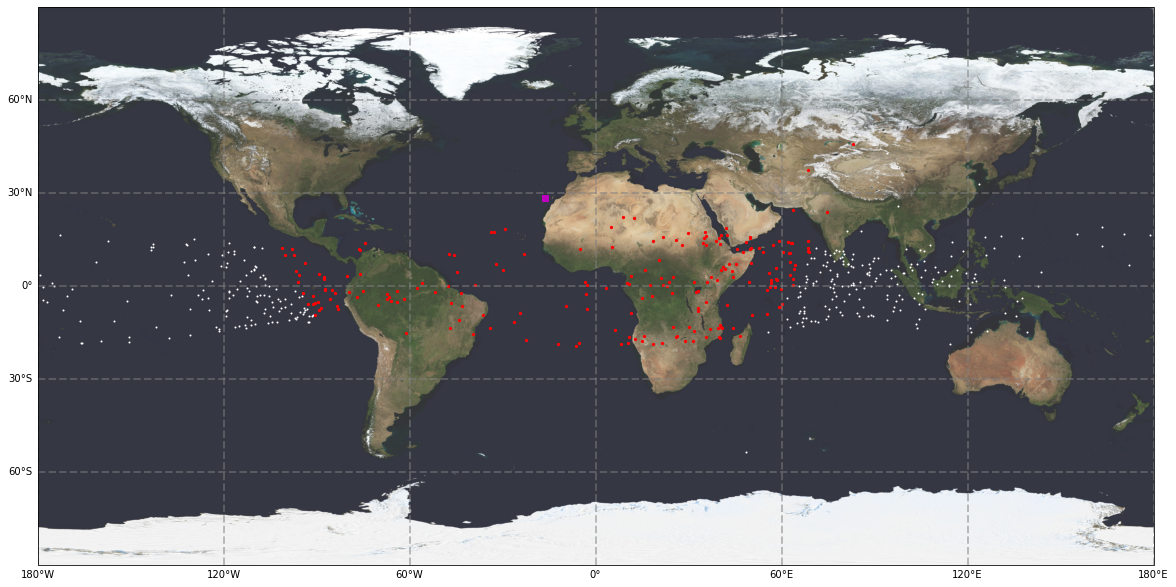

In [6]:
fig = Const.plot_geodetic_view(figsize=(20,15))

fig.savefig('figs/'+const_name+'/'+Observer.name+' Geo view - ' + sim_flags)

In [7]:
np.nansum(Const.topo_pos[...,2]<39000) , np.nanmin(Const.topo_pos[...,2])
np.nanmin(Const.geo_pos[...,2])

29494.63544210835

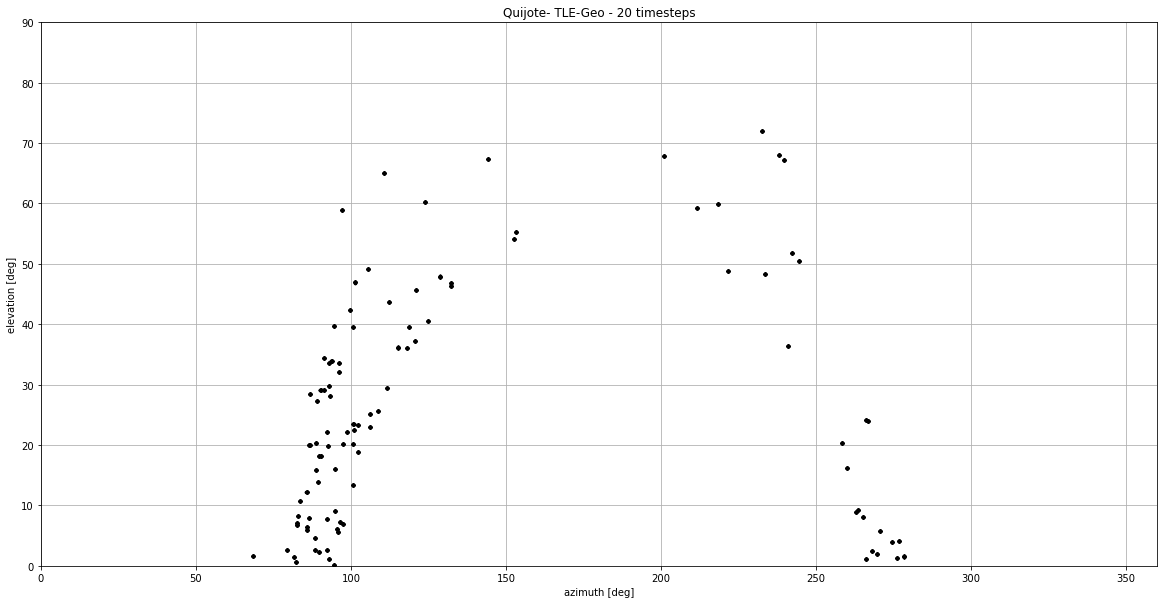

In [37]:

# fig = Const.plot_topo_view(figname = 'fig')
fig = plt.figure(num=10,figsize=(20,10))

steps = np.arange(Const.topo_pos.shape[1])

for a in steps:
    i  = int(a)

    mask_geo = (Const.geo_pos[0,i, :,2]>35700) & (Const.geo_pos[0,i, :,2]<36000)
    mask_vis = Const.geo_pos[0,i, :, 1] > 0
    mask = mask_geo*mask_vis
    plt.plot(Const.topo_pos[0,i, mask, 0],\
             Const.topo_pos[0,i, mask, 1],\
             'k.', markersize=5)
plt.xlim([0, 360])
plt.ylim([0, 90])
plt.xlabel('azimuth [deg]')
plt.ylabel('elevation [deg]')
plt.grid()
plt.title('%s- %s - %d timesteps' % (Const.observer_name,Const.name,\
              len(steps)))
    
fig.savefig('figs/'+const_name+'/'+Observer.name+' Topo view - ' + sim_flags)

In [9]:

#%% Function to plot the sky map    
def plot_sky(value,
             grid_info,
             title = '',
             xlabel = '',
             ylabel = '',
             zunit = '',
             plot_type = 'triangles',
             contours = False,
             savefig = False,
             filename = ''
             ):
    '''
    *************
    * plot_sky  *
    *************
    Parameters
    ----------
    value : TYPE
        DESCRIPTION.
    grid_info : TYPE
        DESCRIPTION.
    title : TYPE, optional
        DESCRIPTION. The default is ''.
    xlabel : TYPE, optional
        DESCRIPTION. The default is ''.
    ylabel : TYPE, optional
        DESCRIPTION. The default is ''.
    zunit : TYPE, optional
        DESCRIPTION. The default is ''.
    plot_type : TYPE, optional
        DESCRIPTION. The default is 'triangles'.
    contours : TYPE, optional
        DESCRIPTION. The default is False.
    savefig : TYPE, optional
        DESCRIPTION. The default is False.
    filename : TYPE, optional
        DESCRIPTION. The default is ''.

    Returns
    -------
    fig : TYPE
        DESCRIPTION.

    '''

    fig = plt.figure(figsize=(9, 6))
    val = value
    ind_plot = np.isfinite(val)

    # color=plt.cm.viridis(val_norm),

    vmin, vmax = np.nanmin(val[ind_plot]), np.nanmax(val[ind_plot])
    val_norm = (val[ind_plot] - vmin) / (vmax - vmin)
    if plot_type == 'bars':
        plt.bar(
            grid_info['cell_lon_low'][ind_plot] ,
            height=grid_info['cell_lat_high'][ind_plot] - grid_info['cell_lat_low'][ind_plot],
            width=grid_info['cell_lon_high'][ind_plot] - grid_info['cell_lon_low'][ind_plot],
            bottom=grid_info['cell_lat_low'][ind_plot],
            color=plt.cm.viridis(val_norm),
            align='edge',
            linewidth = 0,
            )

    if plot_type == 'triangles':
        plt.tricontourf((point_az[0,ind_plot]),point_el[0,ind_plot],val[ind_plot],levels=100,cm='jet')
    

    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    cbar = plt.colorbar(sm)
    cbar.set_label(zunit)
    plt.xlim((point_az[0,ind_plot].min(), point_az[0,ind_plot].max()))
    plt.ylim((point_el[0,ind_plot].min(), point_el[0,ind_plot].max()))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    #plt.plot(sat_sph[:,0],sat_sph[:,1],'xr')
    if contours:
        plt.tricontour(point_az[0,ind_plot],point_el[0,ind_plot],val[ind_plot],
                       levels=[val.max()*0.1,val.max()*0.4,val.max()*0.75],
                       colors=['green','black','red'])
        plt.plot([],color='green',label='%.2f %s'%(val.max()*0.1,zunit))
        plt.plot([],color='black',label='%.2f %s'%(val.max()*0.4,zunit))
        plt.plot([],color='red',label='%.2f  %s'%(val.max()*0.75,zunit))
        plt.legend()
    plt.title(title)
    plt.tight_layout()
    if savefig:
        fig.savefig(filename)

    return fig



In [10]:
ESPFD_iters.shape

(10, 3438, 2000)

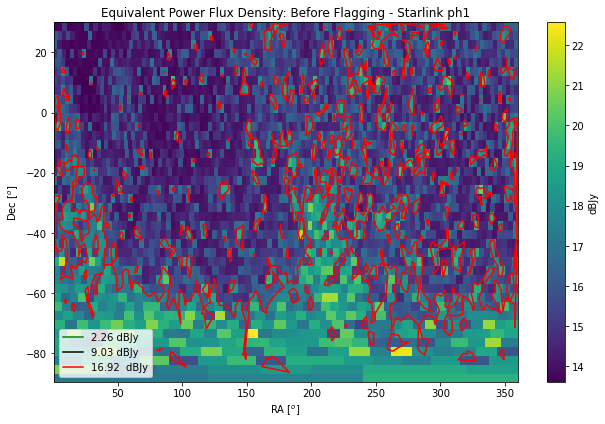

In [11]:
#%% plot the sky map before flagging

ESPFD_m = np.nanmean(np.nanmean(ESPFD_iters,axis=0),axis=-1)

ESPFD_m_dB = 10*np.log10(ESPFD_m/(10**-26)) # W/m2/Hz to dBJy

if equatorial_coords:
    xlabel = 'RA [$^o$]'
    ylabel = 'Dec [$^o$]'
else:
    xlabel = 'Azimuth [$^o$]',
    ylabel = 'Elevation [$^o$]', 
        
A = plot_sky(ESPFD_m_dB,
         grid_info,
         plot_type = 'bars',
         title = 'Equivalent Power Flux Density: Before Flagging - ' + Const.name,
         xlabel = xlabel,
         ylabel = ylabel,
         zunit = 'dBJy',
         savefig = True,
         contours = True,
         filename = 'figs/'+Const.name+'/EPFD_dBJy_before_flag - ' + sim_flags,
        )



In [12]:
pfd_dist

NameError: name 'pfd_dist' is not defined

In [13]:
ESPFD_m  = np.nanmean(ESPFD_iters,axis=-1)
espfd_dist = (np.sort(ESPFD_m) * u.W / u.m ** 2/u.Hz).to(u.dB(u.W/u.m**2/u.Hz))
espfd_dist_all = (np.sort(ESPFD_m.flatten()) * u.W / u.m ** 2).to(cnv.dB_W_m2)

Calculate margin at 98% percentile

In [14]:
espfd98p = np.percentile(ESPFD_m, 98., axis=1)
espfd98p_all = np.percentile(ESPFD_m, 98.)
espfd98p_mean = np.mean(espfd98p)
espfd98p_sigma = np.std(espfd98p, ddof=1)

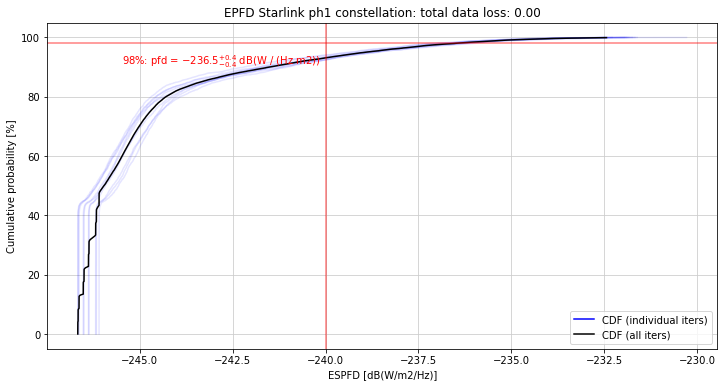

In [22]:
plt.close()
pfd_dist = (espfd_dist)
pfd_dist_all = (espfd_dist_all)
pfd_lim = -240 * u.dB(u.W/u.m**2/u.Hz) # pfd_dist_all.max()#*u.W/u.m**2
data_loss = 0

fig = plt.figure(figsize=(12, 6))
plt.plot(
    pfd_dist.T, 100 * np.linspace(0, 1, pfd_dist.shape[1], endpoint=True),
    'b-', alpha=0.1,
    )
plt.plot([], [], 'b-', label='CDF (individual iters)')

plt.plot(
    pfd_dist_all[::20], 100 * np.linspace(0, 1, pfd_dist_all.size, endpoint=True)[::20],
    'k-', label='CDF (all iters)'
    )
hline = plt.axhline(98., color='r', alpha=0.5)
vline = plt.axvline(pfd_lim.to_value(u.dB(u.W/u.m**2/u.Hz)), color='r', alpha=0.5)
plt.grid(color='0.8')
plt.title('EPFD {:s} constellation: total data loss: {:.2f}'.format(
    const_name, data_loss
    ))
plt.xlabel('ESPFD [dB(W/m2/Hz)]')
plt.ylabel('Cumulative probability [%]')
plt.legend(*plt.gca().get_legend_handles_labels())
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
plt.text(
    xmin + 2, 95.,
    r'98%: pfd = ${0.value:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}$ {0.unit}'.format(
        (espfd98p_all * u.W / u.m ** 2/u.Hz).to(u.dB(u.W/u.m**2/u.Hz)),
        np.abs(((1 + espfd98p_sigma / espfd98p_mean) * cnv.dimless).to_value(cnv.dB)),
        np.abs(((1 - espfd98p_sigma / espfd98p_mean) * cnv.dimless).to_value(cnv.dB)),
        ), color='red', ha='left', va='top',
    )
# plt.text(
#     xmin + 2, 88.,
#     r'$\rightarrow$ RAS margin = ${:.1f}^{{+{:.1f}}}_{{-{:.1f}}}$ dB'.format(
#         pfd_lim.to_value(cnv.dB_W_m2) - (pfd98p_all * u.W / u.m ** 2).to_value(cnv.dB_W_m2),
#         np.abs(((1 - pfd98p_sigma / pfd98p_mean) * cnv.dimless).to_value(cnv.dB)),
#         np.abs(((1 + pfd98p_sigma / pfd98p_mean) * cnv.dimless).to_value(cnv.dB)),
#         ), color='red', ha='left', va='top',
#     )
# plt.text(
#     pfd_lim.to_value(cnv.dB_W_m2) + 0.5, ymin + 20,
#     r'RA.769 exceeded @ ${0.value:.2f}^{{+{1:.2f}}}_{{-{2:.2f}}}$ {0.unit}'.format(
#         100 * u.percent - data_loss,
#         data_loss.to_value(u.percent) - data_loss_m1s,
#         data_loss_p1s - data_loss.to_value(u.percent),
#         ),
#     color='red', ha='left', va='bottom', rotation=90.,
#     )
# plt.savefig(
#     pjoin(FIGPATH, '{:s}_cumulative_data_loss_horizontal.png'.format(basename)),
#     bbox_inches='tight', dpi=100,
#     )
# plt.savefig(
#     pjoin(FIGPATH, '{:s}_cumulative_data_loss_horizontal.pdf'.format(basename)),
#     bbox_inches='tight',
#     )
fig.savefig('figs/'+const_name+'/'+Observer.name+' EPFD_distrib - ' + sim_flags)
plt.show()

Total flagged samples for satellites closer than 1.0 deg :
0.00 %


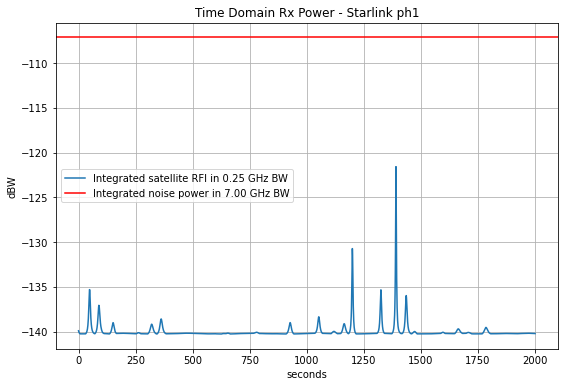

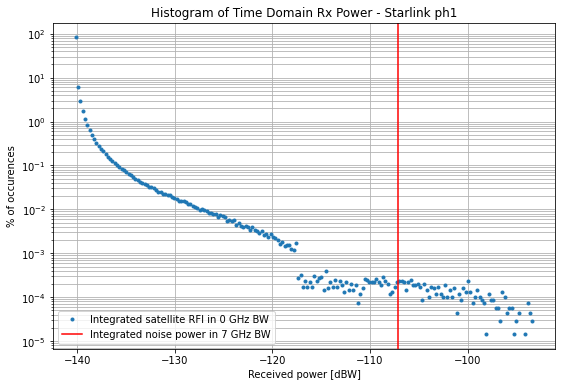

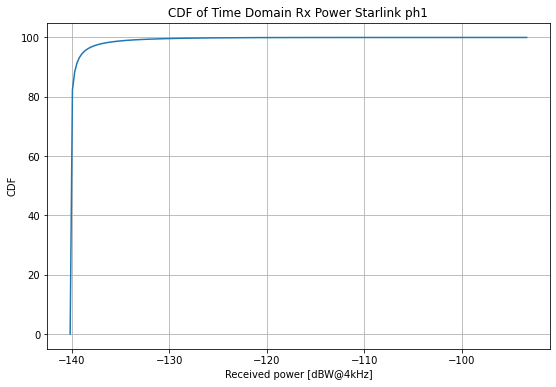

In [23]:

#%% print the amount of data masked
print('Total flagged samples for satellites closer than %s :'%boresight_limit)
print('%.2f %%'%(np.sum(np.isnan(ESPFD_iters))/len(ESPFD_iters.flatten())*100))

#%% flatten time domain plot 
RFI_BW = 2e9/8 # Bandwidth of the RFI, in this case from 10.7-12.7 GHz
RX_BW = 7e9 # Bandwidth of the Receiver, for Band5b is 8.3 to 15.4 GHz

# this is useful to see the received power levels
fig = plt.figure(figsize=(9, 6))
# fig = plt.figure('Time Domain Power', figsize=(9, 6))
time_vector= np.linspace(0,Ntime,int(Ntime/time_step))
plt.plot(time_vector,(Prx_iters[0,200,:]*RFI_BW*u.W).flatten().to(u.dB(u.W)),
         label='Integrated satellite RFI in %.2f GHz BW'%(RFI_BW/1e9))
plt.grid(True, 'both')
plt.xlabel('seconds')
plt.ylabel('dBW')
plt.title('Time Domain Rx Power - '+ Const.name)
# plt.ylim([-190,-120])
plt.axhline(y=(Plim*RX_BW*u.Hz).to_value(u.dB(u.W)),
            label = 'Integrated noise power in %.2f GHz BW'%(RX_BW/1e9),
            color='red')
plt.legend()
fig.savefig('figs/'+const_name+'/'+observer_name+\
            'time domain Prx - ' + sim_flags)

#%%
fig = plt.figure('Histogram of Time Domain Power', figsize=(9, 6))
a,b = np.histogram((Prx_iters[0]*RFI_BW*u.W).flatten().to(u.dB(u.W)).value,200)#, histtype = 'step', density='True')
plt.semilogy((b[1:]+b[0:-1])/2,a/np.sum(a)*100,'.',label = 'Integrated satellite RFI in %d GHz BW'%(RFI_BW/1e9))
plt.grid(True, 'both')
plt.xlabel('Received power [dBW]')
plt.ylabel('% of occurences')
plt.title('Histogram of Time Domain Rx Power - '+ Const.name)
plt.axvline(x=(Plim*RX_BW*u.Hz).to_value(u.dB(u.W)),
            label = 'Integrated noise power in %d GHz BW'%(RX_BW/1e9),
            color='red')
plt.legend()
fig.savefig('figs/'+const_name+'/'+observer_name+\
            'histogram time domain Prx - ' + sim_flags)

a = a/np.sum(a)*100
fig = plt.figure('Cumulative distribution of Time Domain Power', figsize=(9, 6))
cdf = np.zeros(len(a)) 
for i in range(len(a)):
    cdf[i] = np.sum(a[0:i])
    
plt.plot((b[1:]+b[0:-1])/2, cdf)
plt.grid(True, 'both')
plt.xlabel('Received power [dBW@4kHz]')
plt.ylabel('CDF')
plt.title('CDF of Time Domain Rx Power '+ Const.name)
fig.savefig('figs/'+const_name+'/'+observer_name+\
            'CDF time domain Prx - ' + sim_flags)



In [31]:
import pycraf
pycraf.protection.ra769_limits()

<QTable length=21>
frequency bandwidth   T_A   ...     Slim_nu        Efield    Efield_norm 
   MHz       MHz       K    ... dB(W / (Hz m2)) dB(uV2 / m2) dB(uV2 / m2)
 float64   float64  float64 ...     float64       float64      float64   
--------- --------- ------- ... --------------- ------------ ------------
       13         0   50000 ...          -247.6        -54.9        -41.9
       26         0   15000 ...          -249.1        -52.5        -43.3
       74         2     750 ...          -258.2        -50.4        -52.5
      152         3     150 ...          -259.2        -48.7        -53.4
      325         7      40 ...          -257.5        -43.5        -51.7
      408         4      25 ...          -255.1        -43.4        -49.3
      611         6      20 ...          -252.8        -39.2        -47.0
     1414        27      12 ...          -254.4        -34.3        -48.6
     1665        10      12 ...          -250.8        -35.0        -45.0
     2695        10      12 ...          -246.6        -30.9        -40.9
     4995        10      12 ...          -241.3        -25.5        -35.5
    10650       100      12 ...          -239.7        -13.9        -33.9
    15375        50      15 ...          -233.6        -10.9        -27.9
    22355       290      35 ...          -230.8         -0.5        -25.1
    23800       400      15 ...          -232.6         -0.8        -26.8
    31550       500      18 ...          -228.0          4.8        -22.2
    43000      1000      25 ...          -226.4          9.3        -20.7
    89000      8000      12 ...          -227.9         16.8        -22.2
   150000      8000      14 ...          -223.2         21.6        -17.4
   224000      8000      20 ...          -218.2         26.6        -12.4
   270000      8000      25 ...          -215.8         29.0        -10.0

In [32]:
#%% Power Flagging
Plim = -281*u.dB(u.W/u.Hz)

ESPFD_flag = np.copy(ESPFD_iters)
Prx_flag = np.copy(Prx_iters) 
                                       
if power_flag:
#     flag = np.where(Prx_iters*RFI_BW > Plim.value*RX_BW) # in total power
    flag = np.where(Prx_iters > Plim.value) #in PSD

    ESPFD_flag[flag] = np.NaN
    Prx_flag[flag] = np.NaN

    print('Total Power flagging, Plim = %.2f dBW'%(10*np.log10(Plim.value)))
    print('%.2f %%'%(len(flag[0])/len(Prx_iters.flatten())*100))

    # fig = plt.figure('Time Domain Power', figsize=(9, 6))
    # plt.plot((Prx_flag[0]*u.W).flatten().to(u.dB(u.W)))
    # plt.grid(True, 'both')

#%% Total lost samples
print('Total lost samples (masking + power flagging):')
print('%.2f %%'%(np.sum(np.isnan(ESPFD_flag))/len(ESPFD_flag.flatten())*100))


C:\Users\f.divruno\Anaconda3\envs\ska-rfi-satellites\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  


Total Power flagging, Plim = nan dBW
100.00 %
Total lost samples (masking + power flagging):
100.00 %


Total flagged samples for satellites closer than 1.0 deg :
0.00 %
Total Power flagging, Plim = -205.59 dBW
0.03 %
Total lost samples (masking + power flagging):
0.03 %


C:\Users\f.divruno\Anaconda3\envs\ska-rfi-satellites\lib\site-packages\ipykernel_launcher.py:193: RuntimeWarning: Mean of empty slice
C:\Users\f.divruno\Anaconda3\envs\ska-rfi-satellites\lib\site-packages\ipykernel_launcher.py:124: UserWarning: The following kwargs were not used by contour: 'cm'


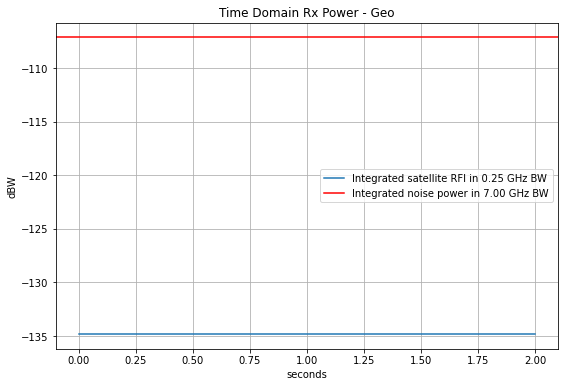

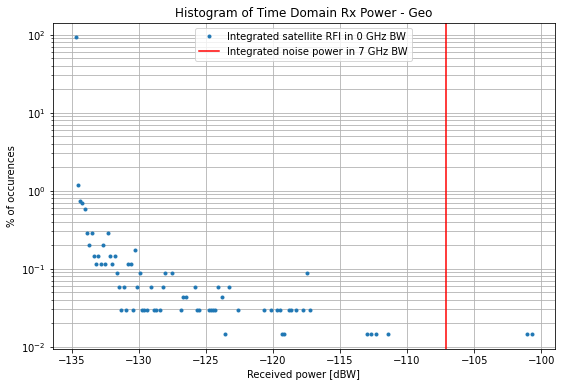

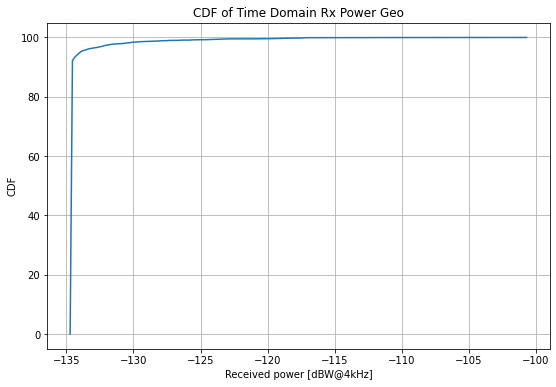

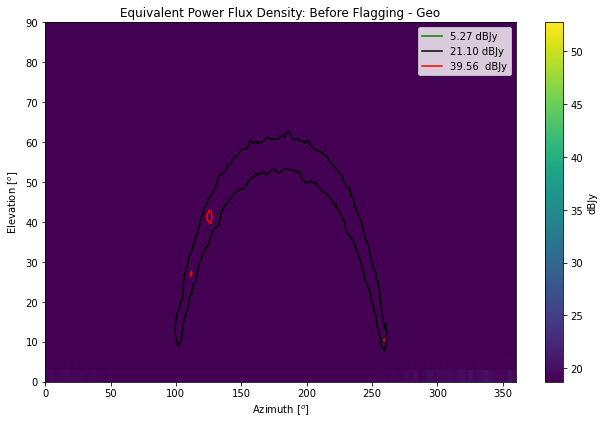

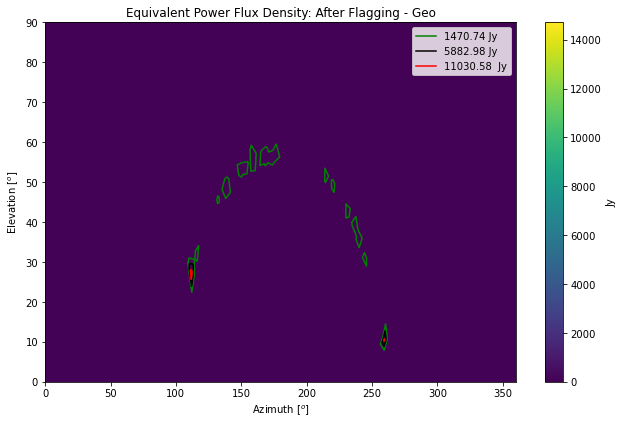

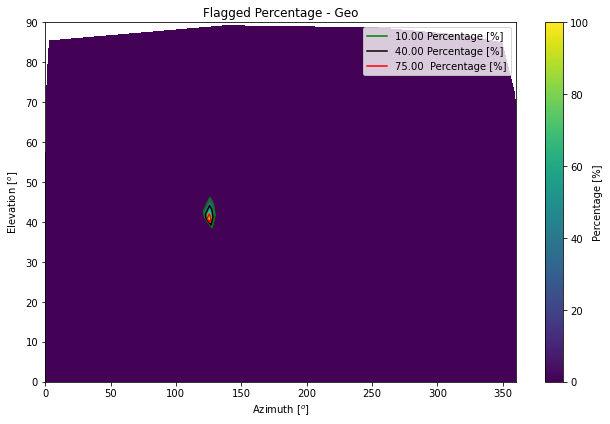

IndexError: index 1 is out of bounds for axis 0 with size 1

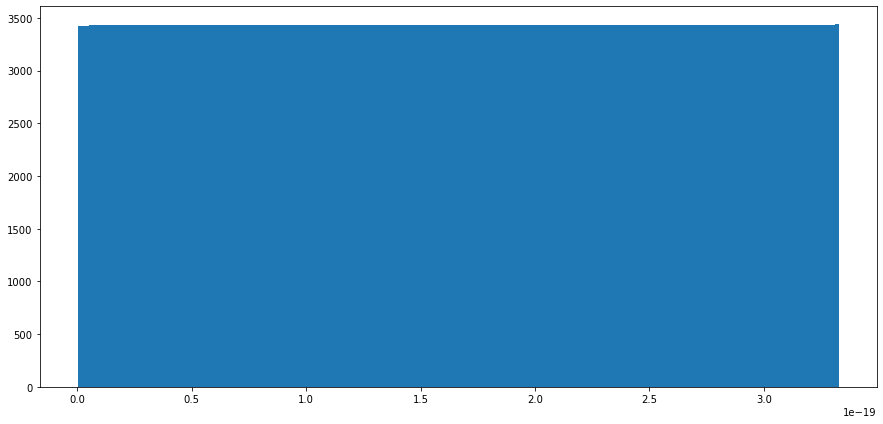

In [57]:

#%% plot the sky map

ESPFD_m = np.nanmean(np.nanmean(ESPFD_flag,axis=0),axis=-1)
ESPFD_m[np.isnan(ESPFD_m)] = 0
val = ESPFD_m/(10**-26) # W/m2/Hz to Jy

plot_sky(val,
         grid_info,
         plot_type = 'bars',
         title = 'Equivalent Power Flux Density: After Flagging - ' + Const.name,
         xlabel = 'Azimuth [$^o$]',
         ylabel = 'Elevation [$^o$]',
         zunit = 'Jy',
         savefig = True,
         contours = True,
         filename = 'figs/'+Const.name+'/EPFD_Jy_after_flag - ' + sim_flags,
         )

#%% plot the flagging sky
flags = np.isnan(ESPFD_flag)
#calculate percentage of flagged samples per direction in the sky
val = np.sum(np.sum(flags,axis=0),axis=1)/flags.shape[0]/flags.shape[2]*100

plot_sky(val,
         grid_info,
         title = 'Flagged Percentage - ' + Const.name,
         xlabel = 'Azimuth [$^o$]',
         ylabel = 'Elevation [$^o$]',
         zunit = 'Percentage [%]',
         savefig = True,
         contours = True,
         plot_type = 'triangles',
         filename = 'figs/'+Const.name+'/Flagged_percentage - ' + sim_flags,
         )

plt.show()


#%% plot the histogram of the received power 
Prx_ave = np.nanmean(Prx_iters,axis=-1)
plt.figure(figsize=[15,7])
[plt.hist(Prx_ave[i], bins = 200, cumulative=1) for i  in range(10)]


In [ ]:
ska.